# Imports de bibliotecas

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Dataset binario do Kaggle

In [2]:
path = kagglehub.dataset_download("rohitudageri/credit-card-details")


df_features = pd.read_csv(os.path.join(path, "Credit_card.csv"))
df_labels   = pd.read_csv(os.path.join(path, "Credit_card_label.csv"))

df = df_features.merge(df_labels, on="Ind_ID", how="inner")

print("Formato do dataset:", df.shape)
print("Colunas:", df.columns.tolist())
print("Distribuição da label:\n", df["label"].value_counts(normalize=True))

Formato do dataset: (1548, 19)
Colunas: ['Ind_ID', 'GENDER', 'Car_Owner', 'Propert_Owner', 'CHILDREN', 'Annual_income', 'Type_Income', 'EDUCATION', 'Marital_status', 'Housing_type', 'Birthday_count', 'Employed_days', 'Mobile_phone', 'Work_Phone', 'Phone', 'EMAIL_ID', 'Type_Occupation', 'Family_Members', 'label']
Distribuição da label:
 label
0    0.886951
1    0.113049
Name: proportion, dtype: float64


# Analise do dataset

In [3]:
print("Valores nulos por coluna:\n", df.isna().sum())

Valores nulos por coluna:
 Ind_ID               0
GENDER               7
Car_Owner            0
Propert_Owner        0
CHILDREN             0
Annual_income       23
Type_Income          0
EDUCATION            0
Marital_status       0
Housing_type         0
Birthday_count      22
Employed_days        0
Mobile_phone         0
Work_Phone           0
Phone                0
EMAIL_ID             0
Type_Occupation    488
Family_Members       0
label                0
dtype: int64


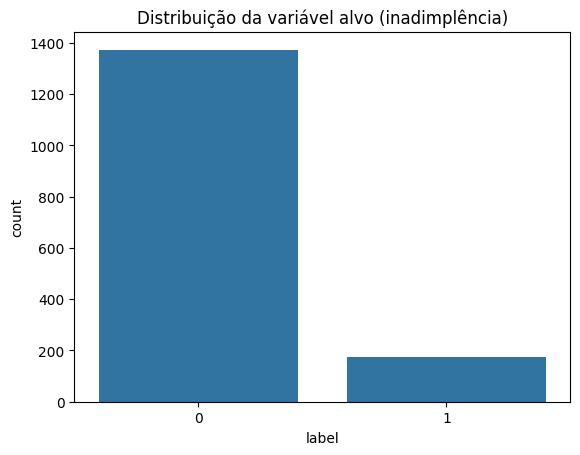

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="label", data=df)
plt.title("Distribuição da variável alvo (inadimplência)")
plt.show()

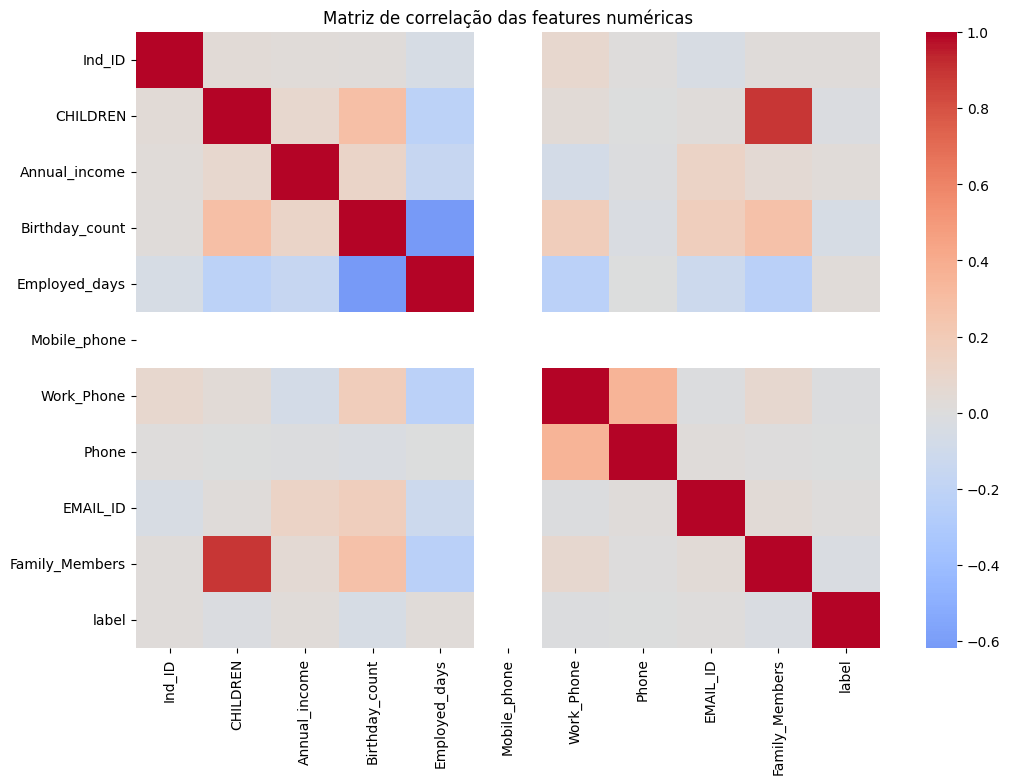

In [5]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de correlação das features numéricas")
plt.show()

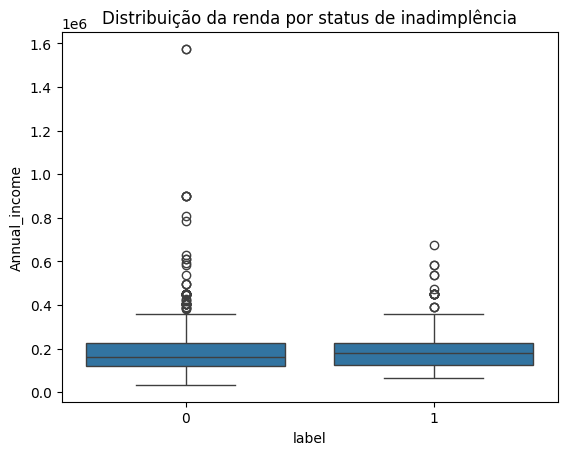

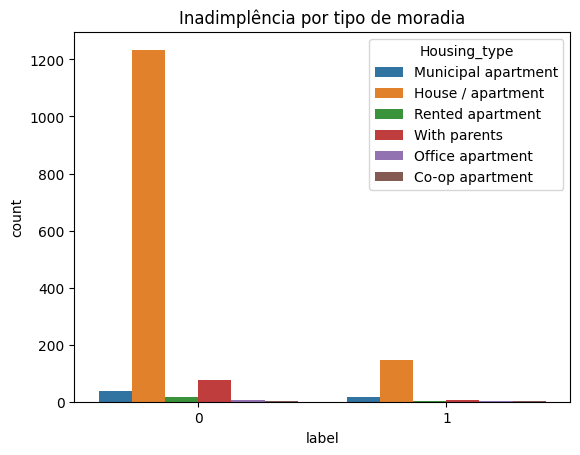

In [6]:
sns.boxplot(x="label", y="Annual_income", data=df)
plt.title("Distribuição da renda por status de inadimplência")
plt.show()

sns.countplot(x="label", hue="Housing_type", data=df)
plt.title("Inadimplência por tipo de moradia")
plt.show()

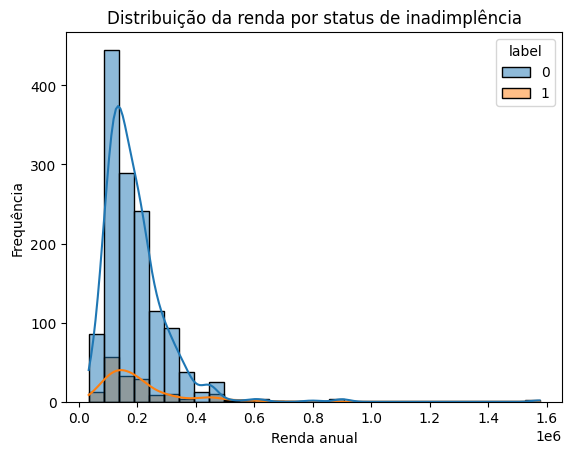

In [7]:
sns.histplot(data=df, x="Annual_income", bins=30, hue="label", kde=True)
plt.title("Distribuição da renda por status de inadimplência")
plt.xlabel("Renda anual")
plt.ylabel("Frequência")
plt.show()

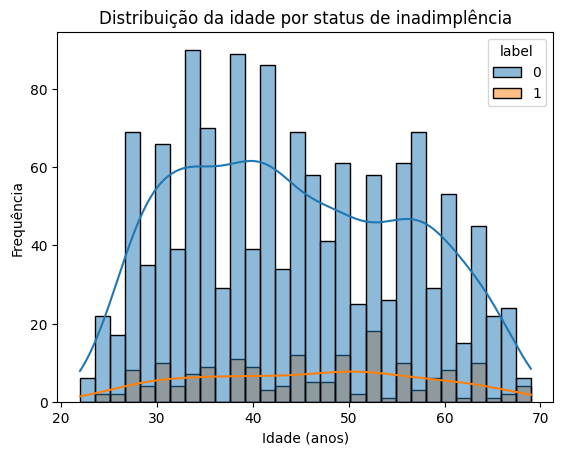

In [8]:
df["Age"] = -(df["Birthday_count"] // 365)

sns.histplot(data=df, x="Age", bins=30, hue="label", kde=True)
plt.title("Distribuição da idade por status de inadimplência")
plt.xlabel("Idade (anos)")
plt.ylabel("Frequência")
plt.show()

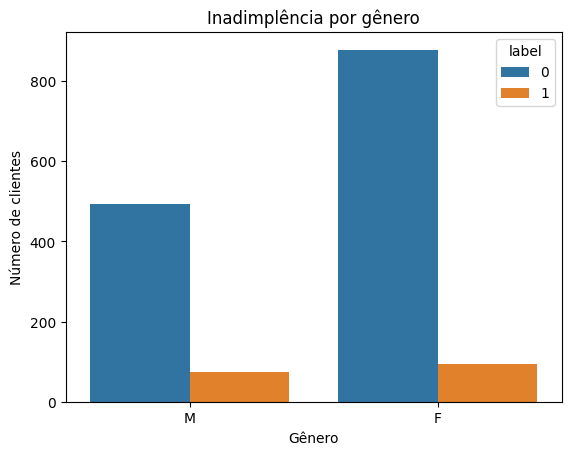

In [9]:
sns.countplot(x="GENDER", hue="label", data=df)
plt.title("Inadimplência por gênero")
plt.xlabel("Gênero")
plt.ylabel("Número de clientes")
plt.show()


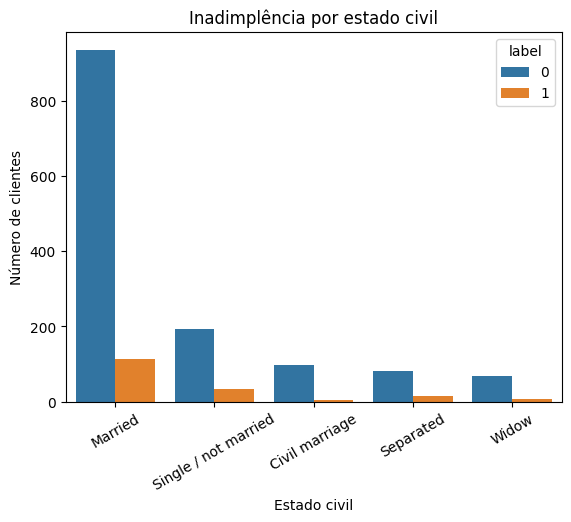

In [10]:
sns.countplot(x="Marital_status", hue="label", data=df)
plt.title("Inadimplência por estado civil")
plt.xlabel("Estado civil")
plt.ylabel("Número de clientes")
plt.xticks(rotation=30)
plt.show()

# Pre processamento de dados

In [11]:
X = df.drop(columns=["Ind_ID", "label"])
y = df["label"].values

for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definindo Metricas

In [12]:
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, "float32")
    y_pred_bin = K.round(y_pred)

    tp = K.sum(K.cast(y_true * y_pred_bin, "float32"))
    fp = K.sum(K.cast((1 - y_true) * y_pred_bin, "float32"))
    fn = K.sum(K.cast(y_true * (1 - y_pred_bin), "float32"))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1


# Construcao do modelo


O modelo escolhido é um perceptron simples: uma rede sequencial (Sequential) com apenas uma camada densa (Dense).  
Essa camada tem 1 neurônio com função de ativação sigmoid, que gera como saída um valor entre 0 e 1 — interpretado como a probabilidade da classe ser 1 (inadimplente).  

- **Camada Dense(1, sigmoid)**  
  Transforma os atributos em uma única saída probabilística, adequada para classificação binária.  
- **Otimizador Adam**  
  Ajusta os pesos da rede durante o treinamento. Ele combina as vantagens do SGD com momento e adaptação da taxa de aprendizado, tornando o processo mais eficiente.  
- **Função de perda (binary_crossentropy)**  
  Mede o erro entre a probabilidade prevista (0–1) e o valor real (0 ou 1).  
  Essa loss é a mais usada para classificação binária.  
- **Métrica Accuracy**  
  Mostra a proporção de acertos globais. Boa para dar uma noção geral, mas enganosa em datasets desbalanceados.  
- **Métrica F1**  
  Equilíbrio entre **Precisão** (quantos dos positivos previstos realmente eram positivos) e **Recall** (quantos dos positivos reais foram detectados).  
  Importante em cenários desbalanceados, como este dataset.

In [13]:
#Construção do modelo

model = Sequential()

#Camada única com sigmoid → saída entre 0 e 1
model.add(Dense(1, activation="sigmoid", input_shape=(X_train.shape[1],)))

#Compilação do modelo
model.compile(
    optimizer=Adam(),                  #Otimizador Adam
    loss="binary_crossentropy",        #Função de perda binária
    metrics=["accuracy", f1_metric]    #Métricas: acurácia e F1
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

# Treinamento

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=50, ##50 epocas
    batch_size=10, #batch size de 10
    validation_split=0.2,
    class_weight={0:1, 1:10},
    verbose=0
)

# Teste do Modelo

In [15]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Acurácia no teste:", acc)
print("F1 no teste:", f1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Acurácia no teste: 0.8870967741935484
F1 no teste: 0.0


#Conclusoes

Como o F1 deu zero, isso significa que o modelo nao conseguiu prever a minoria dos labels - isso acontece pq o modelo esta desbalanceado, para resolver isso teriamos que rebalancear o dataset.

Eu adicionei o parametro class weight do keras para ele dar mais valor para a classe minoritaria - mas mesmo assim nao teve resultado - aqui o necessario seria rebalancear o dataset.

Outro fator aqui - na exploracao dos dados vemos que nada tem uma correlacao muito forte com a label, tem varios dados inuteis no dataset, como work phone, phone, etc...

Idealmente precisariamos limpar as colunas desnecessarias e dar mais peso as correlacionadas.

Outra abordagem interessanter sera inferir mais dados no dataframe - temos poucas amostras e muito poucas evidencias de inadimplmencia

Tambem podemos ver que as distribuicoes do dataset seguem um padrao de quantidade vs inadimplencia x metrica (genero, status civil e idade)